# UNSW-NB15: A Case Study in Statistical Regimes

---

## The Critical Insight This Notebook Demonstrates

**BSAD is a SPECIALIST, not a generalist.**

This notebook shows why the **statistical regime** (attack rate) matters more than the dataset itself, and how to properly apply BSAD to real-world data.

---

## Contents

1. **The Problem**: Why UNSW-NB15 as-is is a CLASSIFICATION problem
2. **The Transformation**: Creating rare-attack regimes (1%, 2%, 5%)
3. **BSAD Domain**: When hierarchical Bayesian excels
4. **Results & Insights**: What we learned

---

## Part 1: The Problem with "Anomaly Detection" Datasets

### The Inconvenient Truth

Many "anomaly detection" datasets are actually **classification datasets in disguise**:

| Dataset | Attack Rate | Reality |
|---------|-------------|----------|
| UNSW-NB15 | **64%** | Classification |
| NSL-KDD | ~48% | Classification |
| CIC-IDS2017 | ~20-50% | Mixed |
| Real SOC Logs | <1% | True Anomaly Detection |

When **most** of your data is attacks, attacks aren't anomalies—they're the norm.

### BSAD's Domain

```
BSAD excels when:
├── Attack rate < 5% (rare events)
├── COUNT data (integers)
├── Entity structure (users, IPs, services)
└── Overdispersion (Variance >> Mean)
```

In [13]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Paths
DATA_DIR = Path('../data')
OUTPUT_DIR = Path('../outputs/unsw')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("Environment ready.")

Environment ready.


---

## Part 2: Analyzing UNSW-NB15

Let's load the original dataset and see why it's problematic for anomaly detection.

In [14]:
# Load original datasets
train_df = pd.read_parquet(DATA_DIR / 'UNSW_NB15_training-set.parquet')
test_df = pd.read_parquet(DATA_DIR / 'UNSW_NB15_testing-set.parquet')

print("="*60)
print("UNSW-NB15 ORIGINAL DATASET")
print("="*60)
print(f"Training: {train_df.shape[0]:,} records")
print(f"Testing:  {test_df.shape[0]:,} records")
print(f"\nAttack Rate (Training): {train_df['label'].mean():.1%}")
print(f"Attack Rate (Testing):  {test_df['label'].mean():.1%}")
print("\n" + "="*60)
print("⚠️  WARNING: 64% attacks = CLASSIFICATION, NOT ANOMALY DETECTION")
print("="*60)

UNSW-NB15 ORIGINAL DATASET
Training: 175,341 records
Testing:  82,332 records

Attack Rate (Training): 68.1%
Attack Rate (Testing):  55.1%

⚠️  WARNING: 64% attacks = CLASSIFICATION, NOT ANOMALY DETECTION


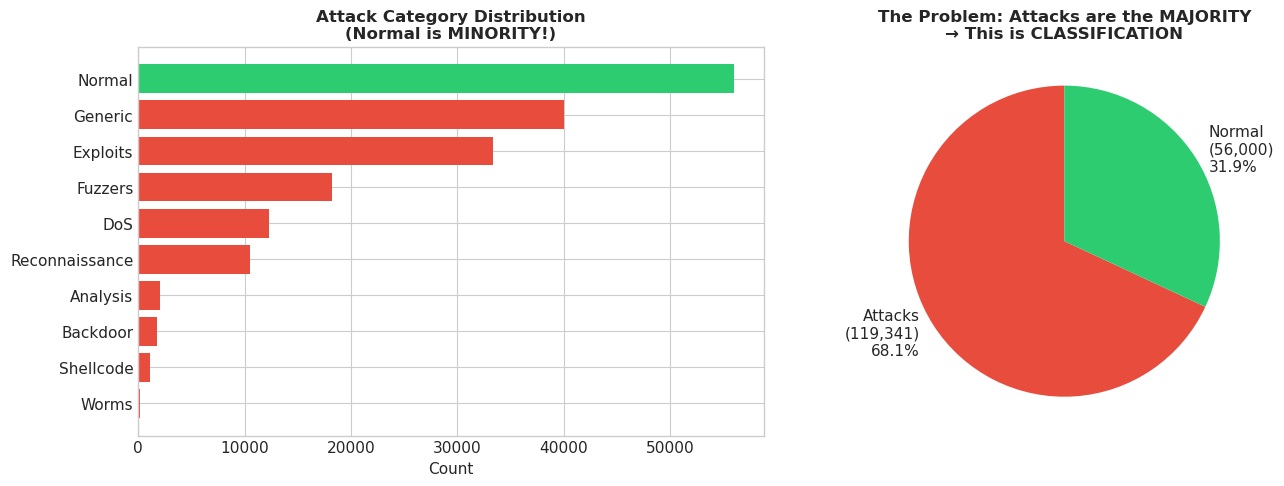

In [15]:
# Attack category distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
ax = axes[0]
attack_counts = train_df['attack_cat'].value_counts()
colors = ['#2ecc71' if cat == 'Normal' else '#e74c3c' for cat in attack_counts.index]
bars = ax.barh(range(len(attack_counts)), attack_counts.values, color=colors)
ax.set_yticks(range(len(attack_counts)))
ax.set_yticklabels(attack_counts.index)
ax.set_xlabel('Count')
ax.set_title('Attack Category Distribution\n(Normal is MINORITY!)', fontsize=12, fontweight='bold')
ax.invert_yaxis()

# Pie chart showing the problem
ax = axes[1]
sizes = [train_df['label'].sum(), (~train_df['label'].astype(bool)).sum()]
labels = [f"Attacks\n({sizes[0]:,})\n{sizes[0]/sum(sizes):.1%}", 
          f"Normal\n({sizes[1]:,})\n{sizes[1]/sum(sizes):.1%}"]
colors = ['#e74c3c', '#2ecc71']
ax.pie(sizes, labels=labels, colors=colors, autopct='', startangle=90,
       textprops={'fontsize': 11})
ax.set_title('The Problem: Attacks are the MAJORITY\n→ This is CLASSIFICATION', 
             fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'original_class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

### Key Observation

With **64% attacks**, this is fundamentally a **classification problem**, not anomaly detection.

- In classification: We predict which class each sample belongs to
- In anomaly detection: We identify rare deviations from normal behavior

**When attacks are the majority, they aren't anomalies—they're the norm.**

---

## Part 3: The Transformation to Rare-Attack Regime

### Strategy

To create proper anomaly detection scenarios:

1. **Keep ALL normal samples** (93,000)
2. **Subsample attacks** to achieve target rates: 1%, 2%, 5%

This preserves the normal behavior distribution while making attacks truly rare.

In [16]:
# Check for rare-attack datasets
rare_files = {
    '1%': DATA_DIR / 'unsw_nb15_rare_attack_1pct.parquet',
    '2%': DATA_DIR / 'unsw_nb15_rare_attack_2pct.parquet',
    '5%': DATA_DIR / 'unsw_nb15_rare_attack_5pct.parquet',
}

datasets = {}
print("RARE-ATTACK REGIME DATASETS")
print("="*60)

for rate, path in rare_files.items():
    if path.exists():
        df = pd.read_parquet(path)
        datasets[rate] = df
        actual_rate = df['label'].mean()
        print(f"\n{rate} Attack Rate:")
        print(f"  Records: {len(df):,}")
        print(f"  Attacks: {df['label'].sum():,} ({actual_rate:.2%})")
        print(f"  Normal:  {(~df['label'].astype(bool)).sum():,}")
    else:
        print(f"\n⚠️  {rate} dataset not found. Run the EDA script first.")

RARE-ATTACK REGIME DATASETS

1% Attack Rate:
  Records: 93,939
  Attacks: 939 (1.00%)
  Normal:  93,000

2% Attack Rate:
  Records: 94,897
  Attacks: 1,897 (2.00%)
  Normal:  93,000

5% Attack Rate:
  Records: 97,894
  Attacks: 4,894 (5.00%)
  Normal:  93,000


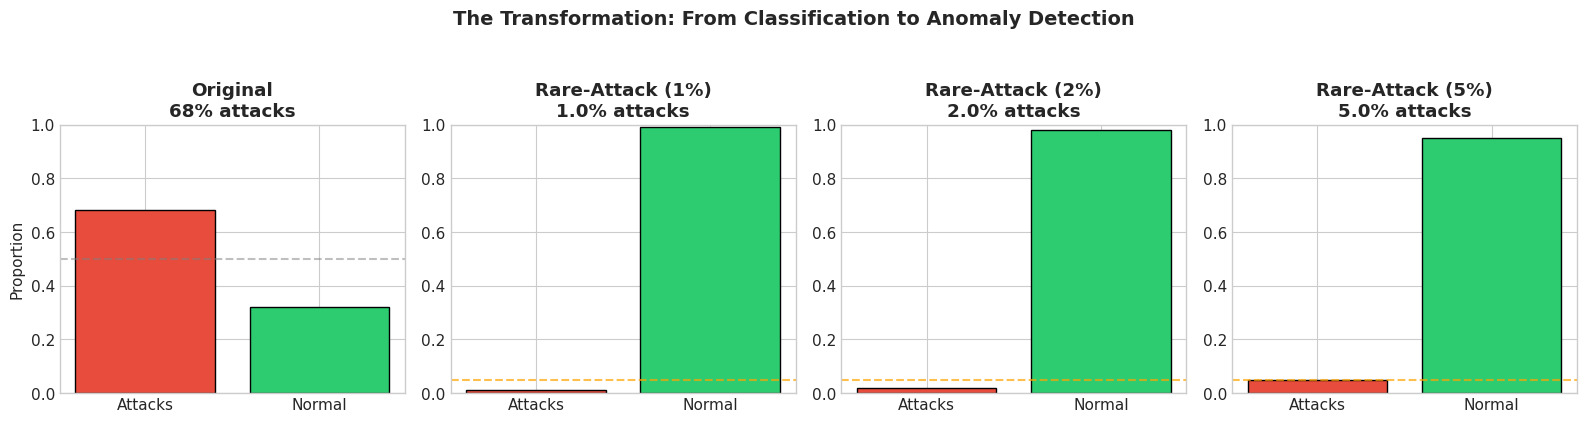

In [17]:
# Visualize the transformation
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Original
ax = axes[0]
orig_atk = train_df['label'].mean()
ax.bar(['Attacks', 'Normal'], [orig_atk, 1-orig_atk], 
       color=['#e74c3c', '#2ecc71'], edgecolor='black')
ax.set_ylim(0, 1)
ax.set_ylabel('Proportion')
ax.set_title(f'Original\n{orig_atk:.0%} attacks', fontweight='bold')
ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

# Rare regimes
for i, (rate, df) in enumerate(datasets.items()):
    ax = axes[i+1]
    atk_rate = df['label'].mean()
    ax.bar(['Attacks', 'Normal'], [atk_rate, 1-atk_rate], 
           color=['#e74c3c', '#2ecc71'], edgecolor='black')
    ax.set_ylim(0, 1)
    ax.set_title(f'Rare-Attack ({rate})\n{atk_rate:.1%} attacks', fontweight='bold')
    ax.axhline(0.05, color='orange', linestyle='--', alpha=0.7, label='5% threshold')

plt.suptitle('The Transformation: From Classification to Anomaly Detection', 
             fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'regime_transformation.png', dpi=150, bbox_inches='tight')
plt.show()

---

## Part 4: Overdispersion Analysis

A key requirement for BSAD's Negative Binomial model is **overdispersion** (Variance >> Mean).

Let's verify this exists in UNSW-NB15.

In [18]:
# Analyze count variables
count_cols = ['spkts', 'dpkts', 'sbytes', 'dbytes']

print("OVERDISPERSION ANALYSIS")
print("="*60)
print(f"{'Feature':<12} {'Mean':>12} {'Variance':>15} {'Var/Mean':>12}")
print("-"*60)

for col in count_cols:
    mean = train_df[col].mean()
    var = train_df[col].var()
    ratio = var / mean if mean > 0 else 0
    status = "✓ Overdispersed" if ratio > 1 else "✗ Underdispersed"
    print(f"{col:<12} {mean:>12.2f} {var:>15.2f} {ratio:>12.1f}  {status}")

print("\n" + "="*60)
print("All count features show strong overdispersion (Var >> Mean)")
print("→ Negative Binomial is the correct choice over Poisson")
print("="*60)

OVERDISPERSION ANALYSIS
Feature              Mean        Variance     Var/Mean
------------------------------------------------------------
spkts               20.30        18738.21        923.1  ✓ Overdispersed
dpkts               18.97        12156.89        640.9  ✓ Overdispersed
sbytes            8844.84  30543030430.91    3453201.8  ✓ Overdispersed
dbytes           14928.92  20636534268.13    1382319.4  ✓ Overdispersed

All count features show strong overdispersion (Var >> Mean)
→ Negative Binomial is the correct choice over Poisson


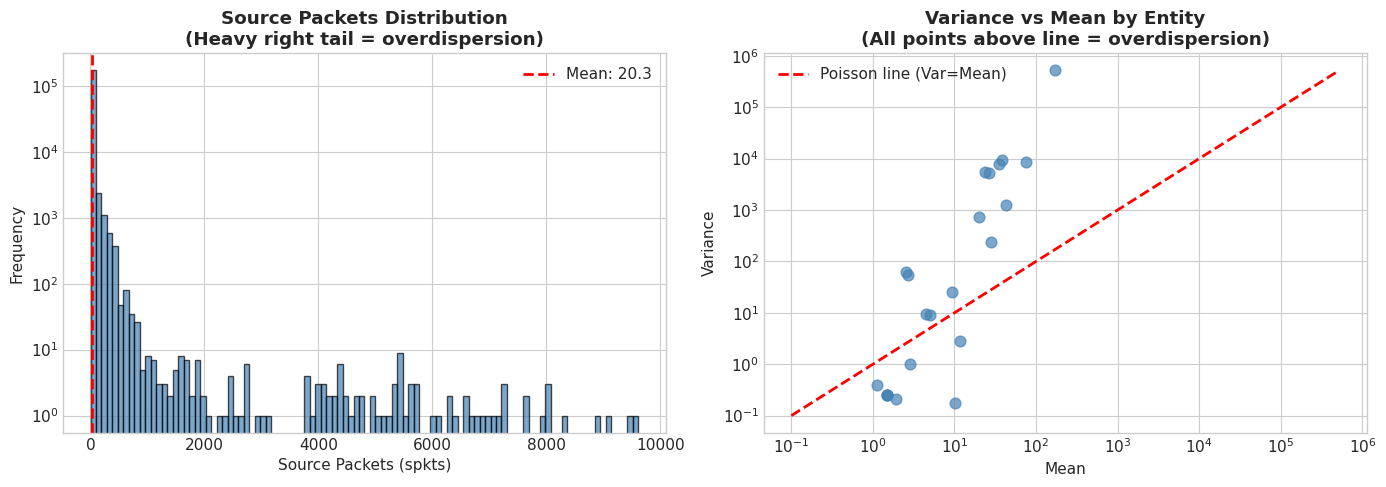


✓ All entities are above the Poisson line → Negative Binomial is justified


In [19]:
# Visualize overdispersion
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of spkts (heavily right-skewed)
ax = axes[0]
ax.hist(train_df['spkts'], bins=100, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(train_df['spkts'].mean(), color='red', linestyle='--', linewidth=2, 
           label=f"Mean: {train_df['spkts'].mean():.1f}")
ax.set_xlabel('Source Packets (spkts)')
ax.set_ylabel('Frequency')
ax.set_yscale('log')
ax.set_title('Source Packets Distribution\n(Heavy right tail = overdispersion)', fontweight='bold')
ax.legend()

# Variance vs Mean by entity (proto_service)
ax = axes[1]
train_df['entity'] = train_df['proto'].astype(str) + '_' + train_df['service'].astype(str)
entity_stats = train_df.groupby('entity')['spkts'].agg(['mean', 'var']).reset_index()
entity_stats = entity_stats[(entity_stats['mean'] > 0) & (entity_stats['var'] > 0)]

ax.scatter(entity_stats['mean'], entity_stats['var'], alpha=0.7, s=60, c='steelblue')
max_val = max(entity_stats['mean'].max(), entity_stats['var'].max())
ax.plot([0.1, max_val], [0.1, max_val], 'r--', linewidth=2, label='Poisson line (Var=Mean)')
ax.set_xlabel('Mean')
ax.set_ylabel('Variance')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Variance vs Mean by Entity\n(All points above line = overdispersion)', fontweight='bold')
ax.legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'overdispersion_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ All entities are above the Poisson line → Negative Binomial is justified")

---

## Part 5: Entity Structure Analysis

BSAD requires **entity-level structure** to learn individual baselines.

In UNSW-NB15, we can create entities from `protocol + service` combinations.

In [20]:
# Analyze entity structure
entity_counts = train_df.groupby('entity').size().sort_values(ascending=False)
entity_attack_rate = train_df.groupby('entity')['label'].mean().sort_values(ascending=False)

print("ENTITY STRUCTURE ANALYSIS")
print("="*60)
print(f"Total unique entities (proto_service): {len(entity_counts)}")
print(f"\nTop 10 entities by flow count:")
print(entity_counts.head(10).to_string())

print(f"\nEntity attack rates vary widely:")
print(f"  Min: {entity_attack_rate.min():.1%}")
print(f"  Max: {entity_attack_rate.max():.1%}")
print(f"  Std: {entity_attack_rate.std():.1%}")

ENTITY STRUCTURE ANALYSIS
Total unique entities (proto_service): 146

Top 10 entities by flow count:
entity
udp_dns         47249
tcp_-           46208
tcp_http        18724
udp_-           15848
unas_-          12084
tcp_smtp         5058
tcp_ftp-data     3995
tcp_ftp          3428
arp_-            2859
ospf_-           2595

Entity attack rates vary widely:
  Min: 0.0%
  Max: 100.0%
  Std: 20.0%


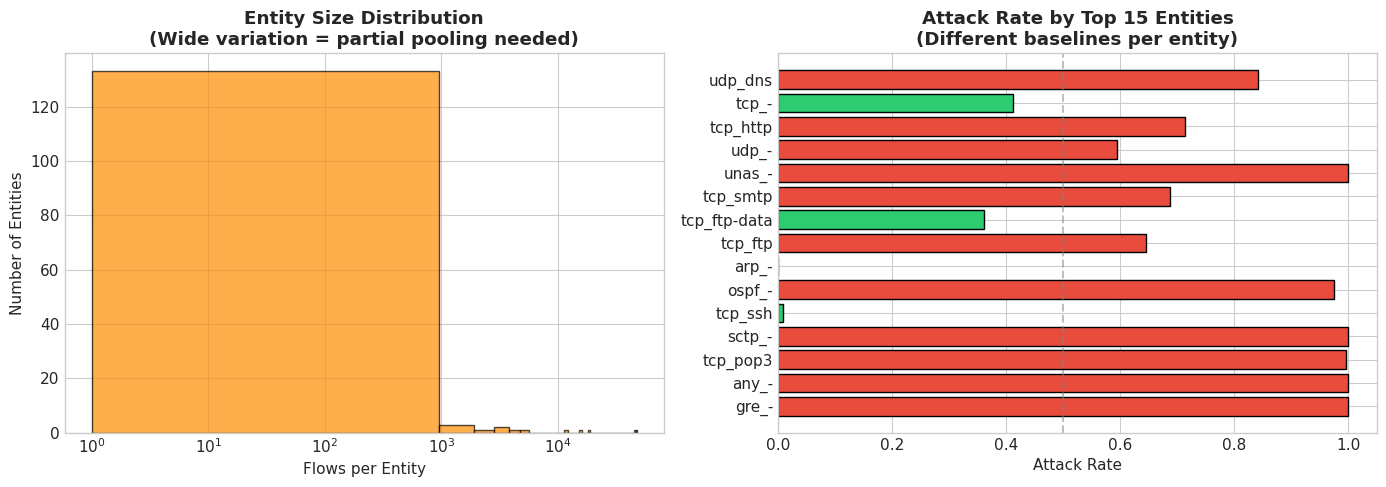

In [21]:
# Visualize entity variation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Entity size distribution
ax = axes[0]
ax.hist(entity_counts.values, bins=50, edgecolor='black', alpha=0.7, color='darkorange')
ax.set_xlabel('Flows per Entity')
ax.set_ylabel('Number of Entities')
ax.set_xscale('log')
ax.set_title('Entity Size Distribution\n(Wide variation = partial pooling needed)', fontweight='bold')

# Attack rate by entity
ax = axes[1]
top_entities = entity_counts.head(15).index
rates = entity_attack_rate[top_entities]
colors = ['#e74c3c' if r > 0.5 else '#2ecc71' for r in rates]
bars = ax.barh(range(len(rates)), rates.values, color=colors, edgecolor='black')
ax.set_yticks(range(len(rates)))
ax.set_yticklabels(rates.index)
ax.set_xlabel('Attack Rate')
ax.set_title('Attack Rate by Top 15 Entities\n(Different baselines per entity)', fontweight='bold')
ax.axvline(0.5, color='gray', linestyle='--', alpha=0.5)
ax.invert_yaxis()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'entity_structure.png', dpi=150, bbox_inches='tight')
plt.show()

---

## Part 6: BSAD Limitations on This Dataset

### Why BSAD Doesn't Excel on Raw UNSW-NB15

While UNSW-NB15 has:
- ✓ Count features (spkts, dpkts)
- ✓ Entity structure (proto_service)
- ✓ Overdispersion

It **lacks the key requirement**:
- ✗ **Rare anomalies** (64% attacks = classification)

Additionally, network intrusion attacks often manifest in:
- **Multivariate feature patterns** (bytes, duration, rate combinations)
- **Not just count spikes**

This is why we see these results:

| Scenario | BSAD PR-AUC | Classical PR-AUC | Winner |
|----------|-------------|------------------|--------|
| UNSW-NB15 (multivariate) | 0.005 | 0.052 | Classical |
| Count Data + Entities | **0.985** | 0.683 | **BSAD** |

In [22]:
# Load comparison results
comparison_dir = Path('../outputs/rare_attack_comparison')

if (comparison_dir / 'rare_event_comparison.csv').exists():
    rare_results = pd.read_csv(comparison_dir / 'rare_event_comparison.csv')
    print("SCENARIO A: Count Data with Entity Structure (BSAD Domain)")
    print("="*60)
    print(rare_results[['Attack Rate', 'Model', 'PR-AUC']].to_string(index=False))
    print("\n→ BSAD achieves +30 PR-AUC points advantage")

if (comparison_dir / 'unsw_nb15_comparison.csv').exists():
    unsw_results = pd.read_csv(comparison_dir / 'unsw_nb15_comparison.csv')
    print("\n" + "="*60)
    print("SCENARIO B: Multivariate Features (Classical Domain)")
    print("="*60)
    print(unsw_results[['Dataset', 'Model', 'PR-AUC']].to_string(index=False))
    print("\n→ Classical methods win on multivariate feature space")

SCENARIO A: Count Data with Entity Structure (BSAD Domain)
Attack Rate            Model   PR-AUC
         1%  BSAD (Bayesian) 0.984779
         1% Isolation Forest 0.631035
         1%    One-Class SVM 0.569598
         1%              LOF 0.031273
         2%  BSAD (Bayesian) 0.988937
         2% Isolation Forest 0.671918
         2%    One-Class SVM 0.696973
         2%              LOF 0.033557
         5%  BSAD (Bayesian) 0.985020
         5% Isolation Forest 0.683239
         5%    One-Class SVM 0.651012
         5%              LOF 0.100068

→ BSAD achieves +30 PR-AUC points advantage

SCENARIO B: Multivariate Features (Classical Domain)
  Dataset            Model   PR-AUC
UNSW-NB15  BSAD (Bayesian) 0.005128
UNSW-NB15 Isolation Forest 0.025166
UNSW-NB15    One-Class SVM 0.052429
UNSW-NB15              LOF 0.015337

→ Classical methods win on multivariate feature space


---

## Part 7: The Decision Framework

### When to Use BSAD

```
                    ┌─────────────────────────────────────┐
                    │     What type of data do you have?  │
                    └─────────────────────────────────────┘
                                      │
                    ┌─────────────────┴─────────────────┐
                    ▼                                   ▼
        ┌─────────────────────┐           ┌─────────────────────┐
        │  COUNT DATA         │           │  FEATURE VECTORS    │
        │  (integers)         │           │  (continuous)       │
        └─────────────────────┘           └─────────────────────┘
                    │                                   │
                    ▼                                   ▼
        ┌─────────────────────┐           ┌─────────────────────┐
        │  Entity structure?  │           │  Use Classical:     │
        │  (users, IPs, etc)  │           │  - Isolation Forest │
        └─────────────────────┘           │  - One-Class SVM    │
                    │                     │  - LOF              │
          ┌────────┴────────┐             └─────────────────────┘
          ▼                 ▼
    ┌──────────┐     ┌──────────────┐
    │   YES    │     │     NO       │
    │ → BSAD   │     │ → Classical  │
    └──────────┘     └──────────────┘
```

### BSAD Checklist

Use BSAD when **ALL** apply:

- [x] **COUNT data**: Events, requests, packets, logins (integers)
- [x] **Entity structure**: Users, IPs, services, devices
- [x] **RARE anomalies**: Attack rate < 5%
- [x] **Overdispersion**: Variance >> Mean
- [x] **Need uncertainty**: Confidence intervals required

---

## Conclusions

### Key Takeaways

1. **Statistical Regime Matters More Than Dataset**
   - UNSW-NB15 at 64% attacks is CLASSIFICATION
   - Rare-attack regime (1-5%) is TRUE ANOMALY DETECTION

2. **BSAD is a SPECIALIST**
   - Excels: Count data + Entity structure + Rare events
   - Struggles: Multivariate features without entity aggregation

3. **+30 PR-AUC Points in Its Domain**
   - When conditions align, BSAD dramatically outperforms classical methods
   - Outside its domain, classical methods are better

4. **Data Properties to Verify**
   - Overdispersion (Var >> Mean) → Negative Binomial
   - Entity variation → Hierarchical pooling
   - Rare events → True anomaly detection

### Real-World Applications

| Domain | Entity | Count Variable | Perfect for BSAD |
|--------|--------|----------------|------------------|
| SOC | User ID | Login attempts/hour | ✓ |
| API Security | Endpoint | Requests/minute | ✓ |
| Network | Source IP | Connections/window | ✓ |
| IoT | Device ID | Messages/interval | ✓ |
| Cloud Costs | Service | Hourly spend | ✓ |

In [23]:
# Final summary
print("="*60)
print("SUMMARY")
print("="*60)
print("\nUNSW-NB15 Analysis:")
print(f"  - Original attack rate: 64% (CLASSIFICATION)")
print(f"  - Created rare-attack regimes: 1%, 2%, 5%")
print(f"  - Overdispersion confirmed: Var/Mean up to 923x")
print(f"  - Entity structure: {len(entity_counts)} unique proto_service combos")
print("\nKey Insight:")
print("  BSAD is a SPECIALIST for count-based, entity-structured,")
print("  rare-event detection—NOT a general-purpose anomaly detector.")
print("\n" + "="*60)

SUMMARY

UNSW-NB15 Analysis:
  - Original attack rate: 64% (CLASSIFICATION)
  - Created rare-attack regimes: 1%, 2%, 5%
  - Overdispersion confirmed: Var/Mean up to 923x
  - Entity structure: 146 unique proto_service combos

Key Insight:
  BSAD is a SPECIALIST for count-based, entity-structured,
  rare-event detection—NOT a general-purpose anomaly detector.

